In [1]:
import matplotlib.pyplot as plt
import numpy as np
from MetaArray import MetaArray
from acq4.util.z_stack_splitter import split_z_stacks

record = MetaArray(file='/home/martin/src/acq4/junk_data/2024.10.17_000/video_000.ma')


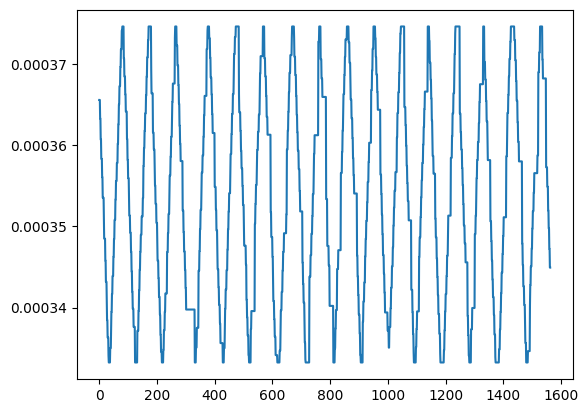

In [3]:
meta = record._info[0]
target_x = meta['translation'][-1, 0]
relevant = meta['translation'][:, 0] == target_x
relevant = relevant.nonzero()[0]
z_positions = meta['translation'][relevant, 2]

# plot the z values
plt.plot(z_positions)

In [4]:
stacks = split_z_stacks(z_positions, 1e-7)
stacks = stacks[1:-1]  # the first and last stacks are usually incomplete
print(len(stacks))

31


In [5]:
cell = record[relevant]
img_stacks = [np.array([cell[i] for i in st]) for st in stacks]
target = (514, 511)

# make the first stack the reference stack
reference = img_stacks.pop(0)
reference.shape

(20, 1024, 1024)

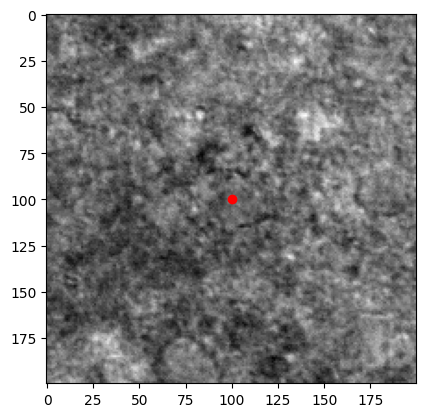

In [6]:
# display region to confirm selection

plt.imshow(reference[reference.shape[0] // 2, 414:614, 411:611], cmap='gray')
plt.scatter(100, 100, c='r')

In [7]:
# reverse every other stack
for i, stack in enumerate(img_stacks):
    if i % 2 == 0:
        img_stacks[i] = stack[::-1]

In [8]:
avg_z_step = (z_positions[stacks[0][-1]] - z_positions[stacks[0][0]]) / (len(stacks[0]) - 1)

In [9]:
from acq4.util.visual_tracker import ObjectStack, PyrLK3DTracker

px = 3.24e-7
reference_stack = ObjectStack(
    reference,
    px_size=px,
    z_step=avg_z_step,
    obj_center=(len(reference) // 2, *target),
)
tracker = PyrLK3DTracker()
tracker.set_tracked_object(reference_stack)


In [10]:
from acq4.util.visual_tracker import ImageStack

result = tracker.next_frame(reference_stack)
print(result['updated_object_stack'].obj_center)e

14 'corners' found at 0.05
[ 10. 514. 511.]


In [11]:
results = [tracker.next_frame(ImageStack(st, px_size=px, z_step=avg_z_step)) for st in img_stacks[:10]]

14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05
14 'corners' found at 0.05


(17, 1024, 1024) [  8 513 511]
(18, 1024, 1024) [  9 513 511]
(17, 1024, 1024) [  8 514 511]
(17, 1024, 1024) [  8 513 511]
(15, 1024, 1024) [  7 513 510]
(16, 1024, 1024) [  8 513 510]
(17, 1024, 1024) [  8 513 511]
(19, 1024, 1024) [  9 514 510]
(16, 1024, 1024) [  9 514 510]
(14, 1024, 1024) [  8 514 510]


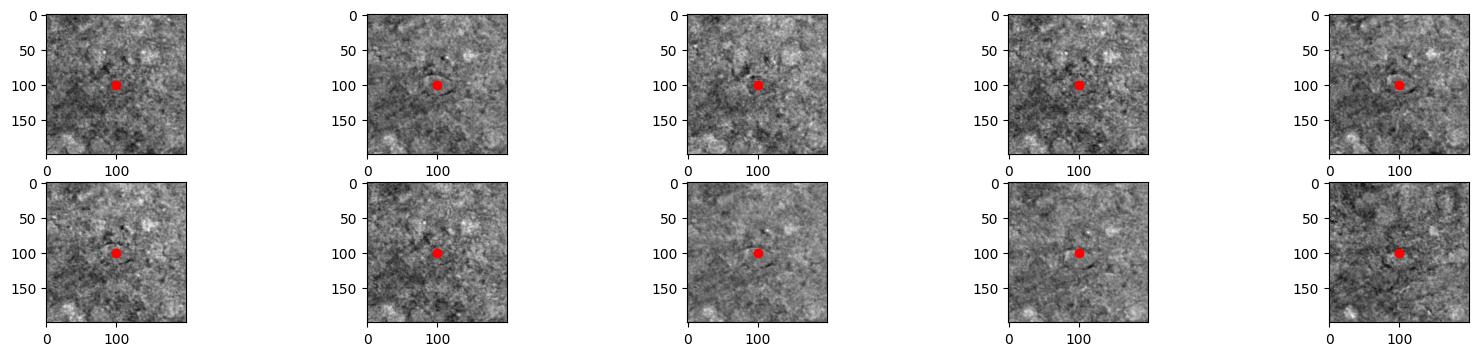

In [12]:
fig, ax = plt.subplots(2, 5, figsize=(20, 4))
for i, r in enumerate(results):
    center = r['updated_object_stack'].obj_center.astype(int)
    r_img = r['updated_object_stack'].data
    print(r_img.shape, center)
    rgn = r_img[r_img.shape[0] // 2, (center[1] - 100):center[1] + 100, center[2] - 100:center[2] + 100]
    ax[i // 5, i % 5].imshow(rgn, cmap='gray')
    ax[i // 5, i % 5].scatter(100, 100, c='r')
